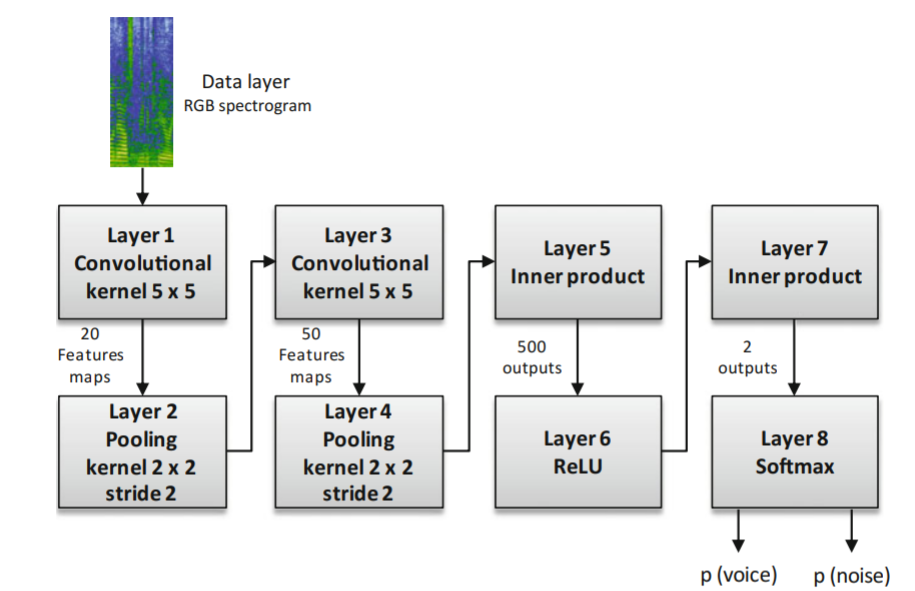

This notebook replicates the model created by Silva et al. [1], which uses the architecture shown above.

The model is trained and tested on various locations and SNR values between SNR+05dB and SNR-20dB on the [QUT-NOISE-TIMIT](https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/) dataset.

For training recording session A is used, for testing the recording session B. 

[1] Silva, D. A., Stuchi, J. A., Violato, R. P. V., & Cuozzo, L. G. D. (2017). Exploring convolutional neural networks for voice activity detection. In Cognitive technologies (pp. 37-47). Springer, Cham.

# Global Paths

In [1]:
path_files = "drive/MyDrive/Master Thesis/"
path_python_files = path_files + 'Python_files'

# Imports

In [2]:
!pip install mlflow --quiet

     |████████████████████████████████| 15.6 MB 9.7 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 210 kB 51.8 MB/s 
     |████████████████████████████████| 181 kB 58.7 MB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 146 kB 47.7 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
     |████████████████████████████████| 53 kB 544 kB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 75 kB 2.6 MB/s 


In [3]:
from datetime import datetime
import glob
import mlflow
import numpy as np
import pexpect
import pickle
import random
import sys

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import datasets, layers, losses, models
from tensorflow.keras.utils import to_categorical

In [4]:
# imports from own files
sys.path.append(path_python_files)
# configs for connecting to databricks
from configs_private import USERNAME, PASSWORD, EXPERIMENT_URL  # credentials for databricks
# helpful Enums
from Enums import AudioClipFileLength, FeatureType, RecPlace, SNR
# get the list of files per chosen SNR and RecPlace
from get_files import get_available_files
# get standardized parameters for feature extraction
from Parameters import Parameters
# extract the features and get the corresponding labels
from create_features_and_labels import get_feature_and_labels
# plot the distribution of files
from plot_files import plot_file_distribution
# get the standardized evaluation of the results
from evaluation_tensorflow import Evaluation

# Set values of Experiment
Set the different values depending on the type of experiment that should be run. When running a sweep of experiments, the values can be adjusted here.

In [53]:
snr = SNR.MINUS_FIVE  # SNR value of the current experiment
labels_per_frame = True  # otherwise labels per window
# Type of feature, either raw audio, MFCC, or Spectrogram
feature = FeatureType.SPECTROGRAM
# if True, ignores raw audio during feature extraction to reduce memory needed
# only needed if raw_audio is feature of model is Wav2vec
ignore_raw_audio = True
# Number of epochs to train on
train_epochs = 100
# split between train and validation set
validation_split = 0.3
# Batch size of the training
batch_size = 32
# If the model should stop early if it is not improving
early_stopping = False
# number of epochs it will wait before stopping early
patience = 10
# optimizer used to train the model (default for all models is Adam)
optimizer='Adam'
# loss function (default is BinaryCrossEntropy, but Hingeloss was also tried)
loss='BinaryCrossentropy'

# Metrics on which to judge the model
metrics = ['accuracy']
# if save_best, the best trained epoch is loaded after training
save_best = True

# number of files for training/testing, can be set to reduce memory
# all files are shuffled before, so it will be split over all categories
nr_train_files = 300
nr_test_files = 300

# Connect to track results
Currently using the databricks community edition to track experiments

In [54]:
# Databricks community version does not allow token generation so instead 
# automatically insert the username and password using expect
child = pexpect.spawn('databricks configure --host https://community.cloud.databricks.com', encoding='utf-8')
child.expect('Username:')
child.sendline(USERNAME)
child.expect('Password:')
child.sendline(PASSWORD)
child.expect('Repeat for confirmation:')
child.sendline(PASSWORD)
print('Connected to Databricks')

Connected to Databricks


In [55]:
mlflow.set_tracking_uri("databricks")
# Create one Experiment per SNR value (from n-20dB to n+05dB in steps of 5)
mlflow.set_experiment(EXPERIMENT_URL+snr.value)

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1010535410834463', experiment_id='1010535410834463', lifecycle_stage='active', name='/Users/d.hamandouche@students.uu.nl/n-05', tags={'mlflow.experiment.sourceName': '/Users/d.hamandouche@students.uu.nl/n-05',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'd.hamandouche@students.uu.nl',
 'mlflow.ownerId': '6054914286087382'}>

In [56]:
mlflow.tensorflow.autolog()
# log the model name and featuretype as additional parameters
mlflow.log_param("model", "CNN-VAD")
mlflow.log_param("Feature", feature)

2022/02/23 13:15:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


# Get Data

In [57]:
wav_files_train = get_available_files(path_files+"QUT-NOISE-TIMIT-new/", snr, AudioClipFileLength.ONE_MINUTE, rec_place=RecPlace.a)
wav_files_test = get_available_files(path_files+"QUT-NOISE-TIMIT-new/", snr, AudioClipFileLength.ONE_MINUTE, rec_place=RecPlace.b)

Total length: 900
Total length: 900


In [58]:
# Shuffle the list of audio files to avoid having just one category
random.shuffle(wav_files_train)
random.shuffle(wav_files_test)

In [59]:
# set all parameters as wanted
parameter = Parameters()
# set_params_specs is the default for Spectrogram
if feature == FeatureType.SPECTROGRAM or feature == FeatureType.RAW_AUDIO:
    print('Using spectrogram or raw audio parameter')
    parameter.set_params_specs()
else:
    print('Using MFCC parameter')
    parameter.set_params_unet()
parameter

Using spectrogram or raw audio parameter


Parameters(window_size=400, sliding_window_size=40960, hop_length=320, n_mfcc=32, n_mels=32, n_fft=400, fmin=0, fmax=8000, sr=16000, htk=False, center=True, wiener_filters=12, use_wiener_filter=False, feature_type=<FeatureType.SPECTROGRAM: 'Spectrogram'>)

# Train Dataset

## Extract Features

100%|██████████| 300/300 [06:00<00:00,  1.20s/it]


Counter({'n-05': 300})
Counter({0: 960711, 1: 805689})
Counter({'sA': 300})
Counter({'CAR-WINUPB-1': 27, 'REVERB-CARPARK-2': 22, 'CAFE-FOODCOURTB-2': 21, 'HOME-LIVINGB-2': 20, 'HOME-KITCHEN-2': 19, 'CAFE-CAFE-1': 18, 'HOME-LIVINGB-1': 17, 'CAFE-CAFE-2': 17, 'STREET-CITY-1': 17, 'REVERB-CARPARK-1': 15, 'CAFE-FOODCOURTB-1': 15, 'CAR-WINDOWNB-1': 15, 'CAR-WINUPB-2': 14, 'HOME-KITCHEN-1': 14, 'CAR-WINDOWNB-2': 14, 'STREET-KG-2': 13, 'STREET-CITY-2': 12, 'STREET-KG-1': 10})


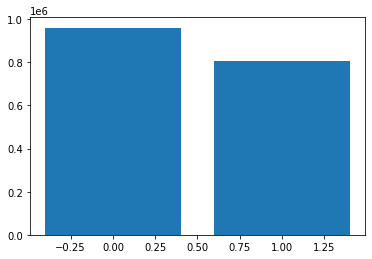

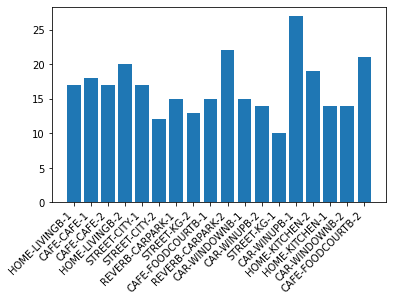

In [60]:
end_train = nr_train_files  # len(wav_files_train)
x_train, labels_train, frames_pos_train, frames_train = get_feature_and_labels(wav_files_train[0:end_train], parameter, ignore_raw_audio=ignore_raw_audio)
y_train = to_categorical(labels_train)
plot_file_distribution(wav_files_train[0:end_train], labels_train)

In [61]:
if feature == FeatureType.RAW_AUDIO:
  # use the raw audio values instead of the spectrogram
  # frames_train contains the samples per frame
  x_train = frames_train

In [62]:
print(x_train.shape, y_train.shape)

(13800, 32, 128) (13800, 128, 2)


## Model

### Spectrogram Model (original)

Models similar to the original paper, the difference is the input shape; next to the small frames, also sliding windows were used as additional context (also to be in line with the U-net and Wav2vec model) 

In [63]:
if feature == FeatureType.SPECTROGRAM:
    # use the normal model as proposed in the paper by Silva et al.
    # added Batchnormalization to reduce overfitting
    shape=(parameter.n_mels, 128, 1)
    model_name = 'CNN-VAD_Spectrogram'
    model = models.Sequential(name=model_name)
    # use padding to keep the same shape
    model.add(layers.Conv2D(20, 5, activation='tanh', input_shape=shape, padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.BatchNormalization())  # added to reduce overfitting
    model.add(layers.Conv2D(50, 5, activation='tanh', padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(layers.BatchNormalization())  # added to reduce overfitting
    model.add(layers.Flatten())
    model.add(layers.Dense(500))
    model.add(layers.Dropout(0.2))  # added to reduce overfitting
    model.add(layers.ReLU())
    if labels_per_frame:
        # if the label is per frame, reshape it to the 128 frames per window
        model.add(layers.Dense(256))
        model.add(layers.Reshape((128, 2)))
    else:
        # if the label is per window, just use 2 nodes
        model.add(layers.Dense(2))
    model.add(layers.Softmax())

    model.summary()

Model: "CNN-VAD_Spectrogram"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 128, 20)       520       
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 64, 20)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_4 (Batc  (None, 16, 64, 20)       80        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 64, 50)        25050     
                                                                 
 average_pooling2d_5 (Averag  (None, 8, 32, 50)        0         
 ePooling2D)                                                     
                                               

### Raw Audio
Adaption of the model for handling raw audio as input. The input has the size of the window and one dimensional convolutions instead of 2d convolutions 

In [64]:
if feature == FeatureType.RAW_AUDIO:
    # no normalization is done, as the model is not overfitting
    shape=(parameter.sliding_window_size, 1)
    model_name = 'CNN-VAD_Raw_Audio'
    model = models.Sequential(name=model_name)
    model.add(layers.Conv1D(20, 5, activation='tanh', input_shape=shape, padding='same'))
    model.add(layers.AveragePooling1D(pool_size=2, strides=2))
    model.add(layers.Conv1D(50, 5, activation='tanh', padding='same'))
    model.add(layers.AveragePooling1D(pool_size=2, strides=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(500))
    model.add(layers.Dropout(0.2))
    model.add(layers.ReLU())
    if labels_per_frame:
        # if the label is per frame, reshape it to the 128 frames per window
        model.add(layers.Dense(256))
        model.add(layers.Reshape((128, 2)))
    else:
        # if the label is per window, just use 2 nodes
        model.add(layers.Dense(2))
    model.add(layers.Softmax())

    model.summary()

### MFCC
The model is the same as the spectrogram model, the only difference is the input shape, which is the number of MFCC instead of number of mels

In [65]:
if feature == FeatureType.MFCC:
    # Number of MFCC used
    shape=(parameter.n_mfcc, 128, 1)
    model_name = 'CNN-VAD_MFCC'
    model = models.Sequential(name=model_name)
    model.add(layers.Conv2D(20, 5, activation='tanh', input_shape=shape, padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(50, 5, activation='tanh', padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(500))
    model.add(layers.Dropout(0.2))
    model.add(layers.ReLU())
    if labels_per_frame:
        model.add(layers.Dense(256))
        model.add(layers.Reshape((128, 2)))
    else:
        model.add(layers.Dense(2))
    model.add(layers.Softmax())

    model.summary()

## Compile and train model

In [66]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "CNN-VAD_Spectrogram"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 128, 20)       520       
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 64, 20)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_4 (Batc  (None, 16, 64, 20)       80        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 64, 50)        25050     
                                                                 
 average_pooling2d_5 (Averag  (None, 8, 32, 50)        0         
 ePooling2D)                                                     
                                               

In [67]:
time = datetime.now()
# create path for saving the results
model_path = f"{path_files}Models/{model.name}_{snr.value}/{time}"
# add callbacks
callbacks = []
if early_stopping:
    # stop early with the given patience
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=patience)
    callbacks.append(callback)
if save_best:
    # save the best weights based on validation loss
    file_path = model_path + "/best_weights.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')
    callbacks.append(checkpoint)

# train the model
history = model.fit(x_train, y_train, epochs = train_epochs, 
                    batch_size=batch_size, validation_split=validation_split, 
                    verbose=1, callbacks=callbacks)

Epoch 1/100
302/302 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.6750
Epoch 1: val_loss improved from inf to 1.17307, saving model to drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-23 13:21:20.403142/best_weights.hdf5
302/302 [==============================] - 4s 11ms/step - loss: 0.5885 - accuracy: 0.6750 - val_loss: 1.1731 - val_accuracy: 0.5547
Epoch 2/100
298/302 [============================>.] - ETA: 0s - loss: 0.5349 - accuracy: 0.7265
Epoch 2: val_loss did not improve from 1.17307
302/302 [==============================] - 3s 9ms/step - loss: 0.5344 - accuracy: 0.7266 - val_loss: 1.3605 - val_accuracy: 0.5368
Epoch 3/100
301/302 [============================>.] - ETA: 0s - loss: 0.4809 - accuracy: 0.7831
Epoch 3: val_loss did not improve from 1.17307
302/302 [==============================] - 3s 10ms/step - loss: 0.4806 - accuracy: 0.7835 - val_loss: 7.0522 - val_accuracy: 0.5297
Epoch 4/100
298/302 [============================>.

2022/02/23 13:26:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Parameter with key epochs was already logged with a value of 10. The attempted new value was 100


## Save Results
Save the model as well as the weights and training history. In case the session crashes or needs to be restarted, the evaluation can still be performed with these elements

In [68]:
model.save(model_path)
# get the best weights
best_weights = model_path + "/best_weights.hdf5"
# save the training history
with open(model_path + '/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

INFO:tensorflow:Assets written to: drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-23 13:21:20.403142/assets
INFO:tensorflow:Assets written to: ram://68c8f731-955a-40e2-b714-78b47980386d/assets


# Evaluation

100%|██████████| 300/300 [06:23<00:00,  1.28s/it]


Counter({'n-05': 300})
Counter({0: 940122, 1: 826278})
Counter({'sB': 300})
Counter({'STREET-KG-2': 20, 'CAFE-FOODCOURTB-1': 20, 'HOME-KITCHEN-1': 20, 'HOME-KITCHEN-2': 19, 'CAR-WINUPB-2': 19, 'REVERB-CARPARK-2': 19, 'CAFE-CAFE-2': 19, 'STREET-CITY-2': 18, 'REVERB-CARPARK-1': 18, 'CAFE-CAFE-1': 17, 'CAR-WINDOWNB-2': 17, 'CAFE-FOODCOURTB-2': 15, 'STREET-CITY-1': 15, 'HOME-LIVINGB-1': 15, 'CAR-WINUPB-1': 14, 'HOME-LIVINGB-2': 12, 'STREET-KG-1': 12, 'CAR-WINDOWNB-1': 11})


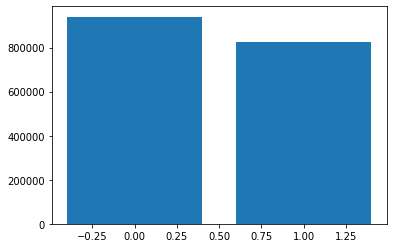

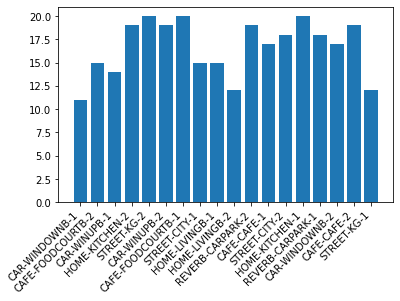

In [69]:
# if the training data still exists, remove it to reduce memory usage
# del x_train, y_train, frames_pos_train, labels_train
end_test = nr_test_files #len(wav_files_test)
# get the features and labels for the test set
x_test, labels_test, frames_pos_test, frames_test = get_feature_and_labels(wav_files_test[0:end_test], parameter, ignore_raw_audio=ignore_raw_audio)
y_test = to_categorical(labels_test)
if feature == FeatureType.RAW_AUDIO:
    # use the raw audio
    x_test = frames_test
# plot the distribution of the test set
plot_file_distribution(wav_files_test[0:end_test], labels_test)

In [70]:
# get the model from the directory
model_name = 'CNN-VAD_Spectrogram'
model_path = f'{path_files}Models/{model_name}_{snr.value}/'
runs = glob.glob(model_path + '/2022*')
print(*runs,sep='\n')  # show each run in a new line
run = runs[-1]  # usually the last one is wanted as that is the newest one

drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-01-18 22:06:42.166238
drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-01-22 12:24:05.859675
drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-22 13:02:20.996899
drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-22 13:03:23.198954
drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-23 12:09:28.641698
drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-23 13:11:09.338495
drive/MyDrive/Master Thesis/Models/CNN-VAD_Spectrogram_n-05/2022-02-23 13:21:20.403142


In [71]:
model = load_model(run)
best_weights = run + "/best_weights.hdf5"

In [72]:
# get the history
history = pickle.load(open(run + '/trainHistoryDict', 'rb'))

In [ ]:
eval = Evaluation(model, run, history, x_test, y_test, snr, parameter, 
                  model_name, best_weights, save_figures=True)
eval.evaluate()

[[775347 164775]
 [103445 722833]]


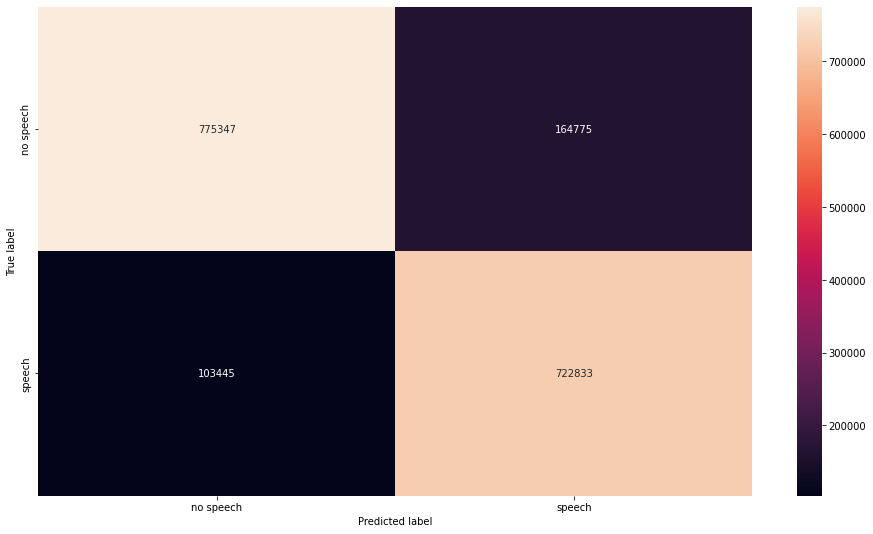

array([[775347, 164775],
       [103445, 722833]])

In [75]:
eval.conf_matrix(post_processing=True)

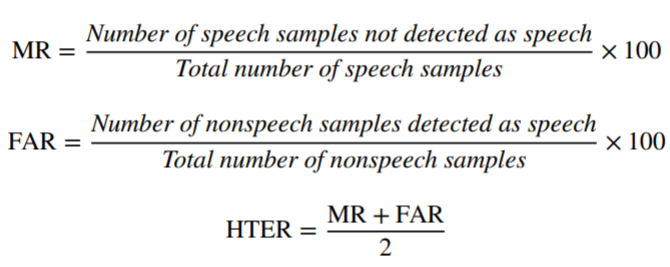

In [76]:
eval.calculate_hter(True)

The post-processing HTER is 15.023% for SNR n-05, with MR being 12.519% and FAR being 17.527%


'The post-processing HTER is 15.023% for SNR n-05, with MR being 12.519% and FAR being 17.527%'